In [1]:
import numpy as np
import pandas as pd

## Step1 download dataset

In [2]:
from sklearn import preprocessing

In [3]:
movies = pd.read_csv('movies.dat', sep = '::', index_col = 0, names = ['MovieID','Title','Genres'])
ratings = pd.read_csv('ratings.dat', sep = '::', header = None, names = ['UserID','MovieID','Rating','Timestamp'])
users = pd.read_csv('users.dat', sep = '::', index_col = 0, header = None, names = ['UserID','Gender','Age','Occupation','Zip-code'])

C:\Users\wsyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\wsyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\wsyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from th

In [4]:
le_user = preprocessing.LabelEncoder()
users.index = le_user.fit_transform(users.index)
ratings['UserID'] = le_user.transform(ratings['UserID'])
users.index.name = 'UserID'

le_movies = preprocessing.LabelEncoder()
movies.index = le_user.fit_transform(movies.index)
ratings['MovieID'] = le_user.transform(ratings['MovieID'])
movies.index.name = 'MovieID'

## Step2 model prediction

In [5]:
def r_prediction(mu, b_U, b_I, p, q):
    prediction = mu + b_U[:,np.newaxis] + b_I[np.newaxis,:] + np.dot(p, q.T)
    return prediction

## Step 3&4 split data

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
ratings_train, ratings_test = train_test_split(ratings,test_size=0.2)
ratings_train, ratings_validation = train_test_split(ratings_train,test_size=0.2)

## Step5 initialize parameters

In [8]:
U = len(users)
I = len(movies)

In [9]:
def initial_parameters(U,I,F):
    b_U_0 = np.random.normal(0,1e-4,U)
    b_I_0 = np.random.normal(0,1e-4,I)
    p_0 = np.random.normal(0,1/max(1,F**(1/2)),(U,F))
    q_0 = np.random.normal(0,1/max(1,F**(1/2)),(I,F))
    return b_U_0, b_I_0, p_0, q_0

## Step6 Loss function, Gradient function, MSE and StochasticGradientDescent function

In [10]:
def Loss(b_U,b_I,p,q,R):
    N = len(R)
    r_pre = mu + b_U[R['UserID']] + b_I[R['MovieID']] + np.sum(p[R['UserID']]*q[R['MovieID']],axis=1)
    loss = sum((r_pre-R['Rating'])**2)/N
    penalty = lambda_p/2*np.sum(p**2)*np.sum(q**2)/N
    return loss+penalty

In [502]:
def StochasticGradientDescent(b_U,b_I,p,q,Ratings,learning_rate=1e-4,tol=1e-7,max_iter=1,batch_size=100000):
    MSE_list_train = []
    MSE_list_validation = []
    b_U_,b_I_,p_,q_ = b_U.copy(),b_I.copy(),p.copy(),q.copy()
    import warnings
    warnings.filterwarnings("ignore")
    N = Ratings.shape[0]
    for e in range(max_iter):
#         if (e%(max_iter//10)==0):
#             print('...' + str(e) + 'Loss:' + str(L))
        perm=np.random.permutation(N)
        for batch in range(0,N,batch_size):
            R = Ratings.iloc[perm[batch:batch+batch_size]]
            U = R['UserID']
            I = R['MovieID']
            r_pre = mu + b_U_[U] + b_I_[I] + np.sum(p_[U]*q_[I])
            Delta = R['Rating'] - r_pre
            for index in range(len(R)):
                u = U.iloc[index]
                i = I.iloc[index]
                delta = Delta.iloc[index]
                delta_b_U = -1 * delta
                delta_b_I = -1 * delta
                delta_p = -1 * q_[i] * delta + lambda_p * p_[u]
                delta_q = -1 * p_[u] * delta + lambda_p * q_[i]
            
                b_U_[u] = -1*learning_rate*delta_b_U + b_U_[u]
                b_I_[i] = -1*learning_rate*delta_b_I + b_I_[i]
                p_[u] = -1*learning_rate*delta_p + p_[u]
                q_[i] = -1*learning_rate*delta_q + q_[i]
#             if((batch//batch_size)%100==0):
#                 print('The '+ str((batch//batch_size)+1) +'st batch has been finished')
#                 print('epoch: ' + str(e) + '; MSE of validation set: ' + str(MSE(b_U_,b_I_,p_,q_,ratings_validation)))
#                 MSE_list.append(MSE(b_U_,b_I_,p_,q_,ratings_validation))
            if((batch//batch_size)%2000==0):
                print('The '+ str((batch//batch_size)+1) +'st batch has been finished')
                print('epoch: ' + str(e) + '; MSE of test set: ' + str(MSE(b_U_,b_I_,p_,q_,X_test)))
#                 MSE_list_train.append(MSE(b_U_,b_I_,p_,q_,ratings_train))
#                 MSE_list_validation.append(MSE(b_U_,b_I_,p_,q_,ratings_validation))
        #print('epoch: ' + str(e) + '; Loss: ' + str(Loss(b_U_,b_I_,p_,q_,Ratings)))
#         print('epoch: ' + str(e) + '; MSE: ' + str(MSE(b_U_,b_I_,p_,q_,ratings_validation)))
   

    return b_U_,b_I_,p_,q_
    #return MSE(b_U_,b_I_,p_,q_,X_test)

In [33]:
def MSE(b_U,b_I,p,q,R):
    N = len(R)
    r_pre = mu + b_U[R['UserID']] + b_I[R['MovieID']] + np.sum(p[R['UserID']]*q[R['MovieID']],axis=1)
    mse = sum((r_pre-R['Rating'])**2)/N
    return mse

## Step7 best learning_rate when F=0

In [462]:
F = 0
b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
lambda_p = .1
mu = ratings_train['Rating'].mean()

In [401]:
StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.005,tol=1e-7,max_iter=1,batch_size=100)

The 1st batch has been finished
epoch: 0; MSE of validation set: 1.2499559111892997
The 1001st batch has been finished
epoch: 0; MSE of validation set: 1.0785096644803869
The 2001st batch has been finished
epoch: 0; MSE of validation set: 1.0032940575560343
The 3001st batch has been finished
epoch: 0; MSE of validation set: 0.9595038410893117
The 4001st batch has been finished
epoch: 0; MSE of validation set: 0.9325686721761346
The 5001st batch has been finished
epoch: 0; MSE of validation set: 0.9128093912777672
The 6001st batch has been finished
epoch: 0; MSE of validation set: 0.8982053930253701


In [402]:
StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.05,tol=1e-7,max_iter=1,batch_size=100)

The 1st batch has been finished
epoch: 0; MSE of validation set: 1.248207477187116
The 1001st batch has been finished
epoch: 0; MSE of validation set: 0.9055598259105674
The 2001st batch has been finished
epoch: 0; MSE of validation set: 0.8760431675542383
The 3001st batch has been finished
epoch: 0; MSE of validation set: 0.865106064618696
The 4001st batch has been finished
epoch: 0; MSE of validation set: 0.8612267667182977
The 5001st batch has been finished
epoch: 0; MSE of validation set: 0.8596003208449029
The 6001st batch has been finished
epoch: 0; MSE of validation set: 0.8598416980319908


In [403]:
StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.1,tol=1e-7,max_iter=1,batch_size=100)

The 1st batch has been finished
epoch: 0; MSE of validation set: 1.2470648314073087
The 1001st batch has been finished
epoch: 0; MSE of validation set: 0.9225074283020802
The 2001st batch has been finished
epoch: 0; MSE of validation set: 0.9098319372860267
The 3001st batch has been finished
epoch: 0; MSE of validation set: 0.9088591529639997
The 4001st batch has been finished
epoch: 0; MSE of validation set: 0.9084563723089607
The 5001st batch has been finished
epoch: 0; MSE of validation set: 0.8986462532715881
The 6001st batch has been finished
epoch: 0; MSE of validation set: 0.9038721983650242


### So set learning rate = .05

## Step 8 record performance when F=0

In [416]:
MSE_list_0 = StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.05,tol=1e-7,max_iter=2,batch_size=100)

The 1st batch has been finished
epoch: 0; MSE of validation set: 1.248389106485843
The 1001st batch has been finished
epoch: 0; MSE of validation set: 0.9033482113884976
The 2001st batch has been finished
epoch: 0; MSE of validation set: 0.8774494951809327
The 3001st batch has been finished
epoch: 0; MSE of validation set: 0.8671313833899423
The 4001st batch has been finished
epoch: 0; MSE of validation set: 0.8596657470199451
The 5001st batch has been finished
epoch: 0; MSE of validation set: 0.8575699105131797
The 6001st batch has been finished
epoch: 0; MSE of validation set: 0.8588603168594942
The 1st batch has been finished
epoch: 1; MSE of validation set: 0.8571524881125435
The 1001st batch has been finished
epoch: 1; MSE of validation set: 0.8581153266101367
The 2001st batch has been finished
epoch: 1; MSE of validation set: 0.8607474884972338
The 3001st batch has been finished
epoch: 1; MSE of validation set: 0.8580543365016319
The 4001st batch has been finished
epoch: 1; MSE o

In [463]:
train_0, validation_0 = StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.05,tol=1e-7,max_iter=2,batch_size=50)

The 1st batch has been finished
epoch: 0; MSE of validation set: 1.2491544747655454
The 2001st batch has been finished
epoch: 0; MSE of validation set: 0.9019213596479962
The 4001st batch has been finished
epoch: 0; MSE of validation set: 0.876952405976691
The 6001st batch has been finished
epoch: 0; MSE of validation set: 0.8683447173541232
The 8001st batch has been finished
epoch: 0; MSE of validation set: 0.8591725107502907
The 10001st batch has been finished
epoch: 0; MSE of validation set: 0.8582233377553917
The 12001st batch has been finished
epoch: 0; MSE of validation set: 0.8577516752470814
The 1st batch has been finished
epoch: 1; MSE of validation set: 0.8571602830416074
The 2001st batch has been finished
epoch: 1; MSE of validation set: 0.8590671790579798
The 4001st batch has been finished
epoch: 1; MSE of validation set: 0.8615727221406322
The 6001st batch has been finished
epoch: 1; MSE of validation set: 0.8587426855942916
The 8001st batch has been finished
epoch: 1; MSE

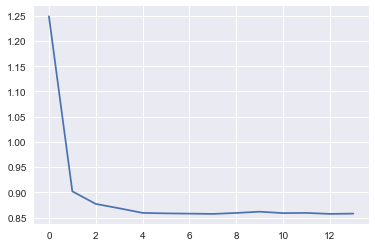

In [464]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(validation_0)
plt.show()

## Step 9 find models with good preformances

#### $\lambda_p$ has no significant influence on models' performance, so I set $\lambda_p$=.1
#### According to step 8, when epoch is greater than 2, mse has no significant decrease, so we set epoch = 2

In [419]:
F = 10
b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
lambda_p = .1
mu = ratings_train['Rating'].mean()

In [426]:
b_U_,b_I_,p_,q_ = StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.05,tol=1e-7,max_iter=1,batch_size=10)

The 1st batch has been finished
epoch: 0; MSE of validation set: 1.3498880995500888
The 10001st batch has been finished
epoch: 0; MSE of validation set: 0.9498850722713259
The 20001st batch has been finished
epoch: 0; MSE of validation set: 0.8985575209708462
The 30001st batch has been finished
epoch: 0; MSE of validation set: 0.8776176770008224
The 40001st batch has been finished
epoch: 0; MSE of validation set: 0.8711392545470951
The 50001st batch has been finished
epoch: 0; MSE of validation set: 0.8668424371784844
The 60001st batch has been finished
epoch: 0; MSE of validation set: 0.8607435780609877


In [428]:
b_U_,b_I_,p_,q_ = StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.05,tol=1e-7,max_iter=1,batch_size=50)

The 1st batch has been finished
epoch: 0; MSE of validation set: 1.3531993655366583
The 2001st batch has been finished
epoch: 0; MSE of validation set: 1.1228051529711618
The 4001st batch has been finished
epoch: 0; MSE of validation set: 0.9970816298078942
The 6001st batch has been finished
epoch: 0; MSE of validation set: 0.939986991519805
The 8001st batch has been finished
epoch: 0; MSE of validation set: 0.9077218307575815
The 10001st batch has been finished
epoch: 0; MSE of validation set: 0.8878455490780386
The 12001st batch has been finished
epoch: 0; MSE of validation set: 0.8756011595242967


In [435]:
b_U_,b_I_,p_,q_ = StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.05,tol=1e-7,max_iter=1,batch_size=100)

The 1st batch has been finished
epoch: 0; MSE of validation set: 1.3578545262178134
The 1001st batch has been finished
epoch: 0; MSE of validation set: nan
The 2001st batch has been finished
epoch: 0; MSE of validation set: nan
The 3001st batch has been finished
epoch: 0; MSE of validation set: nan
The 4001st batch has been finished
epoch: 0; MSE of validation set: nan
The 5001st batch has been finished
epoch: 0; MSE of validation set: nan
The 6001st batch has been finished
epoch: 0; MSE of validation set: nan


### So we set batch size = 50 

### First Model:
$\lambda_p$ = .1.<br/>
epoch = 2<br/>
B = 50<br/>
learning_rate = .025<br/>
F = 10<br/>
<br/>
Performance on validation set = 0.84

In [446]:
F = 10
b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
lambda_p = .1
mu = ratings_train['Rating'].mean()

In [445]:
train_1, validation_1 = StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.025,tol=1e-7,max_iter=2,batch_size=50)

The 1st batch has been finished
epoch: 0; MSE of validation set: 1.3582258221432109
The 2001st batch has been finished
epoch: 0; MSE of validation set: 1.0512620979225717
The 4001st batch has been finished
epoch: 0; MSE of validation set: 0.9567670981383799
The 6001st batch has been finished
epoch: 0; MSE of validation set: 0.9143457923411055
The 8001st batch has been finished
epoch: 0; MSE of validation set: 0.8900608449630348
The 10001st batch has been finished
epoch: 0; MSE of validation set: 0.8722958257764422
The 12001st batch has been finished
epoch: 0; MSE of validation set: 0.8643655504724487
The 1st batch has been finished
epoch: 1; MSE of validation set: 0.8630629609381072
The 2001st batch has been finished
epoch: 1; MSE of validation set: 0.858579638548245
The 4001st batch has been finished
epoch: 1; MSE of validation set: 0.855766192878273
The 6001st batch has been finished
epoch: 1; MSE of validation set: 0.8512331114668784
The 8001st batch has been finished
epoch: 1; MSE 

### Second Model:
$\lambda_p$ = .1.<br/>
epoch = 2<br/>
B = 50<br/>
learning_rate = .02<br/>
F = 50<br/>
<br/>
Performance on validation set = 0.836

In [447]:
F = 50
b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
lambda_p = .1
mu = ratings_train['Rating'].mean()

In [454]:
train_2, validation_2 = StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.02,tol=1e-7,max_iter=2,batch_size=50)

The 1st batch has been finished
epoch: 0; MSE of validation set: 1.2706684185013237
The 2001st batch has been finished
epoch: 0; MSE of validation set: 0.9708791206192199
The 4001st batch has been finished
epoch: 0; MSE of validation set: 0.9115998701860811
The 6001st batch has been finished
epoch: 0; MSE of validation set: 0.8859451891877239
The 8001st batch has been finished
epoch: 0; MSE of validation set: 0.8670356619287028
The 10001st batch has been finished
epoch: 0; MSE of validation set: 0.8582846074872544
The 12001st batch has been finished
epoch: 0; MSE of validation set: 0.8515711574130255
The 1st batch has been finished
epoch: 1; MSE of validation set: 0.8504458984075758
The 2001st batch has been finished
epoch: 1; MSE of validation set: 0.8485425641448439
The 4001st batch has been finished
epoch: 1; MSE of validation set: 0.8448951016809603
The 6001st batch has been finished
epoch: 1; MSE of validation set: 0.8445905705199386
The 8001st batch has been finished
epoch: 1; MS

### Third Model:
$\lambda_p$ = .1.<br/>
epoch = 2<br/>
B = 50<br/>
learning_rate = .02<br/>
F = 100<br/>
<br/>
Performance on validation set = 0.835

In [455]:
F = 100
b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
lambda_p = .1
mu = ratings_train['Rating'].mean()

In [461]:
train_3, validation_3 = StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.02,tol=1e-7,max_iter=2,batch_size=50)

The 1st batch has been finished
epoch: 0; MSE of validation set: 1.259524682815055
The 2001st batch has been finished
epoch: 0; MSE of validation set: 0.9543576100383367
The 4001st batch has been finished
epoch: 0; MSE of validation set: 0.8988764674151152
The 6001st batch has been finished
epoch: 0; MSE of validation set: 0.8746185674919366
The 8001st batch has been finished
epoch: 0; MSE of validation set: 0.8634906182417588
The 10001st batch has been finished
epoch: 0; MSE of validation set: 0.8542871417104662
The 12001st batch has been finished
epoch: 0; MSE of validation set: 0.8476488649413996
The 1st batch has been finished
epoch: 1; MSE of validation set: 0.8457163976763549
The 2001st batch has been finished
epoch: 1; MSE of validation set: 0.8455494611755698
The 4001st batch has been finished
epoch: 1; MSE of validation set: 0.8434729674037038
The 6001st batch has been finished
epoch: 1; MSE of validation set: 0.8416535824609725
The 8001st batch has been finished
epoch: 1; MSE

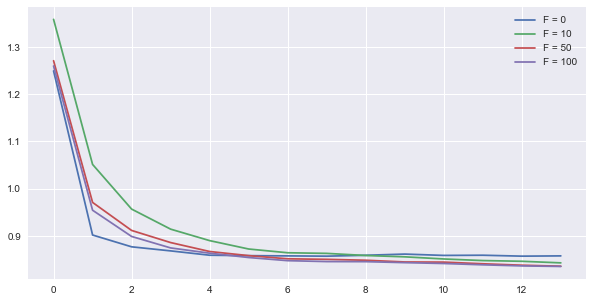

In [476]:
sns.set()
plt.figure(figsize=(10,5))
plt.plot(validation_0, label='F = 0')
plt.plot(validation_1, label='F = 10')
plt.plot(validation_2, label='F = 50')
plt.plot(validation_3, label='F = 100')
plt.legend()
plt.show()

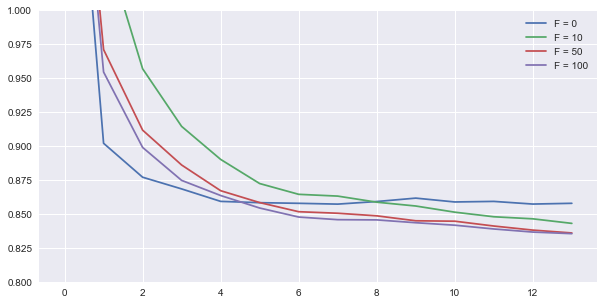

In [475]:
sns.set()
plt.figure(figsize=(10,5))
plt.ylim([0.8, 1])
plt.plot(validation_0, label='F = 0')
plt.plot(validation_1, label='F = 10')
plt.plot(validation_2, label='F = 50')
plt.plot(validation_3, label='F = 100')
plt.legend()
plt.show()

# Step 10 5-Fold cross validation to find the best model

In [486]:
from sklearn.model_selection import KFold

In [494]:
kf = KFold(n_splits=5)
ratings_fold = pd.concat([ratings_train, ratings_validation])
kf.get_n_splits(ratings_fold)

5

In [497]:
F = 10
b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
lambda_p = .1
mu = ratings_train['Rating'].mean()

result_1 = 0
for train_index, test_index in kf.split(ratings_fold):
    X_train, X_test = ratings_fold.iloc[train_index], ratings_fold.iloc[test_index]
    result_1 += StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,X_train,learning_rate=.025,tol=1e-7,max_iter=2,batch_size=50)
result_1/5

The 1st batch has been finished
epoch: 0; MSE of test set: 1.342135424893671
The 2001st batch has been finished
epoch: 0; MSE of test set: 1.042891523120401
The 4001st batch has been finished
epoch: 0; MSE of test set: 0.9625193407107709
The 6001st batch has been finished
epoch: 0; MSE of test set: 0.917624591260676
The 8001st batch has been finished
epoch: 0; MSE of test set: 0.8943795395227482
The 10001st batch has been finished
epoch: 0; MSE of test set: 0.8774926765072094
The 12001st batch has been finished
epoch: 0; MSE of test set: 0.8676009839370621
The 1st batch has been finished
epoch: 1; MSE of test set: 0.8604889407596971
The 2001st batch has been finished
epoch: 1; MSE of test set: 0.8586775636920754
The 4001st batch has been finished
epoch: 1; MSE of test set: 0.8540828551096057
The 6001st batch has been finished
epoch: 1; MSE of test set: 0.8513275489263916
The 8001st batch has been finished
epoch: 1; MSE of test set: 0.8513882628091638
The 10001st batch has been finished

0.8468436822273077

In [498]:
F = 50
b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
lambda_p = .1
mu = ratings_train['Rating'].mean()

result_2 = 0
for train_index, test_index in kf.split(ratings_fold):
    X_train, X_test = ratings_fold.iloc[train_index], ratings_fold.iloc[test_index]
    result_2 += StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.02,tol=1e-7,max_iter=2,batch_size=50)
result_2/5

The 1st batch has been finished
epoch: 0; MSE of test set: 1.2659057026174283
The 2001st batch has been finished
epoch: 0; MSE of test set: 0.9539892019341676
The 4001st batch has been finished
epoch: 0; MSE of test set: 0.8862623058450464
The 6001st batch has been finished
epoch: 0; MSE of test set: 0.8558656317104858
The 8001st batch has been finished
epoch: 0; MSE of test set: 0.8362185616106066
The 10001st batch has been finished
epoch: 0; MSE of test set: 0.8228514687447402
The 12001st batch has been finished
epoch: 0; MSE of test set: 0.8154618308280719
The 1st batch has been finished
epoch: 1; MSE of test set: 0.8130942614370689
The 2001st batch has been finished
epoch: 1; MSE of test set: 0.8115260962039806
The 4001st batch has been finished
epoch: 1; MSE of test set: 0.8079607022905012
The 6001st batch has been finished
epoch: 1; MSE of test set: 0.8036925679902296
The 8001st batch has been finished
epoch: 1; MSE of test set: 0.8010865700506299
The 10001st batch has been finis

0.807993386138848

In [500]:
F = 100
b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
lambda_p = .1
mu = ratings_train['Rating'].mean()

result_3 = 0
for train_index, test_index in kf.split(ratings_fold):
    X_train, X_test = ratings_fold.iloc[train_index], ratings_fold.iloc[test_index]
    result_3 += StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.02,tol=1e-7,max_iter=2,batch_size=50)
result_3/5

The 1st batch has been finished
epoch: 0; MSE of test set: 1.2563485744371305
The 2001st batch has been finished
epoch: 0; MSE of test set: 0.9385771046148726
The 4001st batch has been finished
epoch: 0; MSE of test set: 0.876299695750274
The 6001st batch has been finished
epoch: 0; MSE of test set: 0.8472828574396264
The 8001st batch has been finished
epoch: 0; MSE of test set: 0.8300142052911237
The 10001st batch has been finished
epoch: 0; MSE of test set: 0.8193052725553993
The 12001st batch has been finished
epoch: 0; MSE of test set: 0.8129946894818959
The 1st batch has been finished
epoch: 1; MSE of test set: 0.8102595072802801
The 2001st batch has been finished
epoch: 1; MSE of test set: 0.8077971378409605
The 4001st batch has been finished
epoch: 1; MSE of test set: 0.8044298277631866
The 6001st batch has been finished
epoch: 1; MSE of test set: 0.8013205216528115
The 8001st batch has been finished
epoch: 1; MSE of test set: 0.7986294189661642
The 10001st batch has been finish

0.8055887321714732

### So the third model is the best
$\lambda_p$ = .1.<br/>
epoch = 2<br/>
B = 50<br/>
learning_rate = .02<br/>
F = 100<br/>
<br/>
Performance on validation set = 0.835

# Step 11 measure the performance of the best model on the test set data.

In [503]:
F = 100
b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
lambda_p = .1
mu = ratings_train['Rating'].mean()

b_U_,b_I_,p_,q_ = StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_fold,learning_rate=.02,tol=1e-7,max_iter=2,batch_size=50)

The 1st batch has been finished
epoch: 0; MSE of test set: 1.257723461737915
The 2001st batch has been finished
epoch: 0; MSE of test set: 0.9449915631383656
The 4001st batch has been finished
epoch: 0; MSE of test set: 0.8850495361009166
The 6001st batch has been finished
epoch: 0; MSE of test set: 0.8587288486594735
The 8001st batch has been finished
epoch: 0; MSE of test set: 0.8419668442344933
The 10001st batch has been finished
epoch: 0; MSE of test set: 0.8318234102707314
The 12001st batch has been finished
epoch: 0; MSE of test set: 0.823211800867573
The 14001st batch has been finished
epoch: 0; MSE of test set: 0.8182521966107171
The 16001st batch has been finished
epoch: 0; MSE of test set: 0.8151965816991446
The 1st batch has been finished
epoch: 1; MSE of test set: 0.814098066227131
The 2001st batch has been finished
epoch: 1; MSE of test set: 0.8143508847751578
The 4001st batch has been finished
epoch: 1; MSE of test set: 0.8122219763603407
The 6001st batch has been finishe

In [504]:
MSE(b_U_,b_I_,p_,q_,ratings_test)

0.8307080992065834